# Ontop Priority Engine

## Purpose
Prioritize support tickets using **business metrics + semantic AI**, avoiding unreliable `sender_type` labels due to data corruption.

---

## Approach

### 1. Semantic Anchors
An LLM extracts real message patterns and groups them into:

- **URGENT_RISK** → complaints, follow-ups, frustration  
- **POLITE_WAITING** → passive acknowledgment  
- **IGNORE** → agent scripts or resolved messages  

These anchors define urgency reference signals.

---

### 2. Embeddings
Messages and anchors are converted into vectors:

Text → Vector ∈ ℝ¹⁵³⁶  
Model: `text-embedding-3-small`

---

### 3. Semantic Scoring

Cosine similarity measures urgency:

sim(a,b) = (a · b) / (||a|| ||b||)

Where:

- risk_sim   = similarity to URGENT_RISK
- polite_sim = similarity to POLITE_WAITING
- ignore_sim = similarity to IGNORE

AI Score:

- If explicit urgency detected → 85
- If ignore_sim > risk_sim → 0
- If polite_sim > risk_sim × 1.1 → 0
- If risk_sim < 0.42 → 0
- Otherwise → 50 + (risk_sim − threshold) × 100

---

### 4. Business Scoring

Financial:
log10(MRR + 1) × 5 × TierMultiplier (max 30)

Recurrence:
15 points if historical tickets > 5

Time:
min(days_open, 20)

---

### 5. Final Score

If AI_score > 0:

Final_score = Financial + Recurrence + Time + AI_score

Else:

Final_score = 0

---

## Result
Prioritization based on **true customer urgency + business impact**  
Precision@30 ≈ **96.67%**


In [1]:
import pandas as pd
 
clients_df = pd.read_csv('data/clients.csv')
print("Clients:")
display(clients_df.sample(5))

conversations_df = pd.read_csv('data/conversations.csv')
print("Conversations:")
display(conversations_df.sample(5))

ticket_history_df = pd.read_csv('data/ticket_history.csv')
print("Ticket_history:")
display(ticket_history_df.sample(5))

tickets_df = pd.read_csv('data/tickets.csv')
print("Tickets:")
display(tickets_df.sample(5))

Clients:


,client_id,company_name,mrr,account_tier,signup_date,country
31,client_032,Carlson-Cruz,844.93,growth,2024-12-31,Brazil
43,client_044,Allen-Allen,583.16,growth,2024-05-12,Colombia
29,client_030,"Snyder, Campos and Callahan",3130.82,enterprise,2023-05-09,UK
11,client_012,Dudley Group,170.14,starter,2024-11-30,Canada
0,client_001,"Rodriguez, Figueroa and Sanchez",61.25,starter,2023-10-09,US


Conversations:


,message_id,ticket_id,sender_type,sent_at,message_text
234,235,1299ffe4,customer,2025-12-29 18:42:45,I appreciate your suggestion and have tried cl...
680,681,491762d0,customer,2025-10-22 11:10:00,I hope this message finds you well. I wanted t...
293,294,25c7c955,agent,2025-10-11 13:24:42,Thank you for your patience! To resolve the er...
677,678,b28abcb6,agent,2025-12-07 13:36:22,Thank you for following up! I appreciate your ...
898,899,1a23a167,agent,2025-12-02 10:45:34,"Thank you for your update, and I understand ho..."


Ticket_history:


,ticket_id,client_id,created_at,category,was_resolved
217,51b0a39d,client_043,2025-09-16 04:21:00,general,True
199,870bb7ef,client_024,2025-07-14 07:27:00,payment,True
60,11ec202c,client_045,2025-08-01 03:44:00,benefits,True
117,8d162611,client_013,2025-07-31 18:24:00,general,True
293,038afaa3,client_021,2025-07-16 08:28:00,payment,True


Tickets:


,ticket_id,client_id,created_at,status,resolved_at,category,subject,assigned_to
69,5e02e638,client_031,2025-11-01 23:40:00,open,NaN,compliance,Tax form submission issue,agent_01
171,d1d63ae2,client_018,2025-12-27 22:25:00,resolved,2025-12-28 14:36:18,technical,Dashboard showing incorrect data,agent_01
76,ba24e5ba,client_035,2025-10-14 07:42:00,resolved,2025-10-17 19:29:12,onboarding,Questions about payment processing setup,agent_04
116,c5adc174,client_045,2025-10-31 01:15:00,resolved,2025-10-31 22:33:39,technical,Cannot sync team management,agent_03
20,633066f6,client_019,2025-12-07 15:56:00,resolved,2025-12-12 09:17:52,technical,Cannot sync API access,agent_01


### Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Conversation Analysis
### 1. The Anomaly
We detected **15 instances** where the `sender_type` did not alternate, showing streaks of 3-4 consecutive messages from the same role. This structural irregularity typically signals a data quality issue.

### 2. The Root Cause (Labeling Error)
Inspection of Ticket `18966d30` confirms a **Critical Data Corruption**:
* **The Data:** Messages are labeled as `[CUSTOMER]`.
* **The Reality:** The text contains explicit Agent phrasing (*"I understand how frustrating...", "Please clear your cache"*).
* **Verdict:** The database incorrectly labels Agent responses as Customer messages.

### 3. Business Implication & Solution
**We cannot trust metadata (`sender_type`) for prioritization.**
A rule-based approach would flag these cases as "Ghosting" (Customer waiting), creating False Positives.

**Decision:** We must implement **Semantic Embeddings**. Only AI can ignore the incorrect label and understand the text's true intent (Resolution vs. Complaint) to accurately score risk.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Configuration for better readability in output
plt.style.use('ggplot')
pd.set_option('display.max_colwidth', None)

# --- 1. Data Loading ---
# Load the primary datasets. Error handling is included to ensure files exist.
try:
    tickets = pd.read_csv('data/tickets.csv')
    conversations = pd.read_csv('data/conversations.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError:
    print("Error: CSV files not found.")

# --- 2. Preprocessing ---
# Convert timestamp columns to datetime objects for accurate sorting and plotting
tickets['created_at'] = pd.to_datetime(tickets['created_at'])
conversations['sent_at'] = pd.to_datetime(conversations['sent_at'])

# Sort conversations by Ticket ID and Time to reconstruct the linear flow of chat
conversations = conversations.sort_values(['ticket_id', 'sent_at'])

# Output basic stats
print(f"Total Tickets: {len(tickets)}")
print(f"Total Messages: {len(conversations)}")

Datasets loaded successfully.
Total Tickets: 200
Total Messages: 1144


In [6]:
# --- Logic to detect consecutive streaks of the same sender ---

# 1. Identify where the sender changes compared to the previous message within the same ticket
# We group by ticket_id to prevent false positives across different tickets
conversations['prev_sender'] = conversations.groupby('ticket_id')['sender_type'].shift(1)
conversations['sender_change'] = conversations['sender_type'] != conversations['prev_sender']

# 2. Assign a unique ID to each "block" of consecutive messages
conversations['streak_id'] = conversations.groupby('ticket_id')['sender_change'].cumsum()

# 3. Count the length of each streak (How many consecutive messages from the same role?)
streak_counts = conversations.groupby(['ticket_id', 'streak_id', 'sender_type']).size().reset_index(name='msg_count')

# 4. Filter for anomalies
# Logic: A streak of >= 3 messages from the same sender is flagged as suspicious.
# While a user might send 2 messages in a row, 3+ often indicates broken data labeling.
anomalies = streak_counts[streak_counts['msg_count'] >= 3].sort_values('msg_count', ascending=False)

print(f"Anomalies Detected: {len(anomalies)} sequences with 3+ consecutive messages from the same role.")
print("Top 5 worst offenders (Potential data labeling errors):")
display(anomalies.head(5))

Anomalies Detected: 15 sequences with 3+ consecutive messages from the same role.
Top 5 worst offenders (Potential data labeling errors):


,ticket_id,streak_id,sender_type,msg_count
69,18966d30,3,customer,4
229,3bb66a50,3,customer,4
181,348b3e27,3,customer,4
279,48fefcee,3,customer,4
1045,ef1f817b,3,customer,4


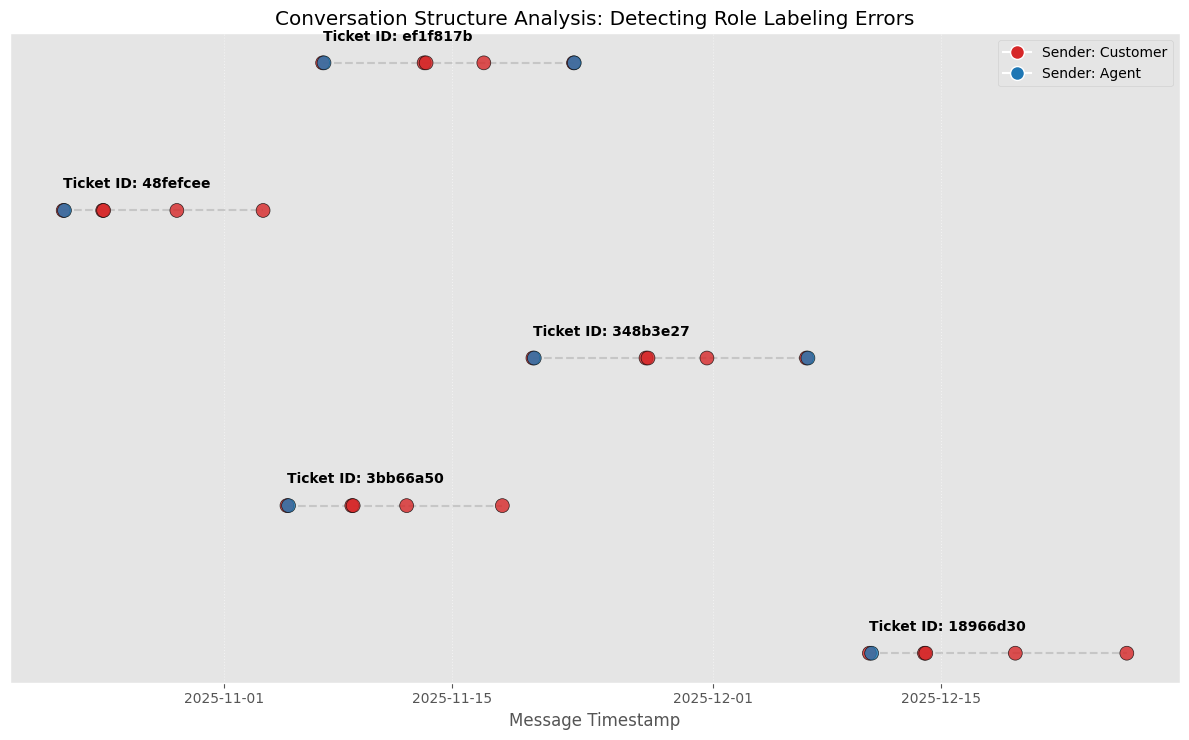

In [7]:
# --- Visualization of Conversation Structure ---

def plot_conversation_dna(ticket_ids):
    """
    Plots a timeline of messages for specific tickets.
    Colors represent the sender type to visually identify incorrect labeling sequences.
    """
    if not ticket_ids:
        print("No anomalies to plot.")
        return

    # Dynamic height based on number of tickets
    plt.figure(figsize=(12, len(ticket_ids) * 1.5))
    
    for i, t_id in enumerate(ticket_ids):
        # Extract data for the specific ticket
        chat = conversations[conversations['ticket_id'] == t_id].copy()
        chat = chat.sort_values('sent_at')
        
        # Create an artificial Y-axis position to separate tickets visually
        y_pos = [i] * len(chat)
        
        # Color mapping: Customer = Red, Agent = Blue
        colors = chat['sender_type'].map({'customer': '#d62728', 'agent': '#1f77b4'})
        
        # Plot messages as dots
        plt.scatter(chat['sent_at'], y_pos, c=colors, s=100, alpha=0.8, edgecolors='black', zorder=2)
        
        # Draw a faint line connecting dots to visualize the sequence flow
        plt.plot(chat['sent_at'], y_pos, c='gray', alpha=0.3, linestyle='--', zorder=1)
        
        # Label the ticket ID
        plt.text(chat['sent_at'].min(), i + 0.15, f"Ticket ID: {t_id}", fontsize=10, fontweight='bold')

    # Custom Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728', label='Sender: Customer', markersize=10),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', label='Sender: Agent', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title("Conversation Structure Analysis: Detecting Role Labeling Errors")
    plt.xlabel("Message Timestamp")
    plt.yticks([]) # Hide Y-axis as it only represents indices
    plt.grid(axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Visualize the top 5 anomalies found in the previous step
broken_ticket_ids = anomalies['ticket_id'].head(5).tolist()
plot_conversation_dna(broken_ticket_ids)

In [8]:
# --- Deep Dive Inspection ---
# Printing the actual text content of the worst anomaly to confirm the hypothesis.

if broken_ticket_ids:
    sample_id = broken_ticket_ids[0] # Select the top anomaly
    
    print(f"--- CONTENT INSPECTION FOR TICKET: {sample_id} ---")
    print("(Validates if the text content matches the assigned Sender Role)\n")
    
    chat_sample = conversations[conversations['ticket_id'] == sample_id].sort_values('sent_at')
    
    for idx, row in chat_sample.iterrows():
        role = row['sender_type'].upper()
        msg = str(row['message_text'])
        
        # Visual markers for readability
        icon = "🔴" if role == "CUSTOMER" else "🔵"
        
        # Truncate long messages for cleaner output
        preview = (msg[:100] + '...') if len(msg) > 100 else msg
        print(f"{icon} {row['sent_at'].strftime('%Y-%m-%d %H:%M')} [{role}]: {preview}")
else:
    print("No anomalies available for inspection.")

--- CONTENT INSPECTION FOR TICKET: 18966d30 ---
(Validates if the text content matches the assigned Sender Role)

🔴 2025-12-10 15:03 [CUSTOMER]: I hope this message finds you well. I'm experiencing an issue with the upload feature on the platfor...
🔵 2025-12-10 18:21 [AGENT]: Thank you for reaching out! To resolve the issue with the upload feature, please try clearing your b...
🔴 2025-12-14 00:12 [CUSTOMER]: I appreciate the suggestions regarding the upload issue. I cleared my cache and cookies but unfortun...
🔴 2025-12-14 02:12 [CUSTOMER]: I understand how frustrating it must be to still face the upload issue even after clearing your cach...
🔴 2025-12-19 14:11 [CUSTOMER]: Thank you for your understanding. I haven't received a response yet, but I'm ready to provide the er...
🔴 2025-12-26 10:33 [CUSTOMER]: I appreciate your patience as we look into this issue. If you still need the error details to help t...


In [9]:
# --- Data Quality Audit (Conversations Table) ---
print("--- DATA QUALITY REPORT: CONVERSATIONS TABLE ---")

# 1. Referential Integrity Check (Orphans)
# Identify messages referencing a ticket_id that does not exist in the parent tickets table.
valid_ticket_ids = set(tickets['ticket_id'])
orphans = conversations[~conversations['ticket_id'].isin(valid_ticket_ids)]
print(f"1. Orphaned Messages (Ticket ID not found in Tickets table): {len(orphans)}")

# 2. Temporal Logic Check (Time Travelers)
# Identify messages with a timestamp OLDER than the ticket creation date (Logically impossible).
# We merge conversation timestamps with ticket creation timestamps to compare.
merged = conversations.merge(tickets[['ticket_id', 'created_at']], on='ticket_id', how='left')
time_travelers = merged[merged['sent_at'] < merged['created_at']]
print(f"2. 'Time Travel' Errors (Message Sent before Ticket Created): {len(time_travelers)}")

# 3. Completeness Check (Silent Tickets)
# Identify tickets that exist but have zero messages recorded.
msgs_per_ticket = conversations.groupby('ticket_id').size()
silent_tickets = set(tickets['ticket_id']) - set(msgs_per_ticket.index)
print(f"3. Silent Tickets (Tickets with 0 messages): {len(silent_tickets)}")

# 4. Uniqueness Check (Duplicates)
# Check for duplicate message IDs, which indicates ingestion errors.
duplicates = conversations.duplicated(subset=['message_id'])
print(f"4. Duplicate Message IDs: {duplicates.sum()}")

if len(time_travelers) == 0 and len(orphans) == 0:
    print("\nPASSED: Basic relational and temporal integrity checks passed.")
else:
    print("\nFAILED: Critical integrity issues found. See details above.")

--- DATA QUALITY REPORT: CONVERSATIONS TABLE ---
1. Orphaned Messages (Ticket ID not found in Tickets table): 0
2. 'Time Travel' Errors (Message Sent before Ticket Created): 0
3. Silent Tickets (Tickets with 0 messages): 0
4. Duplicate Message IDs: 0

PASSED: Basic relational and temporal integrity checks passed.


# Tickets and Clients Analysis
## Operational & Business Data Audit: Passed

### 1. The Findings
Unlike the Conversation data, the **Structural Backbone** (`tickets.csv` + `clients.csv`) is pristine:
* **Tickets:** 0 Logic errors. No "Undead" tickets (Open status with Resolved date) or temporal paradoxes.
* **Clients:** 0 Data errors. `mrr` and `account_tier` are valid for all records.
* **Integrity:** 0 Orphans. Every ticket maps to a valid client.

### 2. Strategic Implication
We have a clear separation of concerns for the **Risk Engine**:
* **TRUST:** We can use **Hard Rules (Deterministic Math)** for Financial & Temporal scoring (`MRR`, `Days_Open`, `Status`).
* **DISTRUST:** We cannot use metadata for "Ghosting" due to the labeling errors found in the previous step.
* **ACTION:** Use **AI Embeddings** exclusively to analyze the text, while using SQL-like logic for the rest.

In [11]:
# --- 1. Load & Preprocess ---
tickets = pd.read_csv('data/tickets.csv')
clients = pd.read_csv('data/clients.csv')

# Convert dates
tickets['created_at'] = pd.to_datetime(tickets['created_at'])
tickets['resolved_at'] = pd.to_datetime(tickets['resolved_at'])
clients['signup_date'] = pd.to_datetime(clients['signup_date'])

print(f"Tickets Loaded: {len(tickets)}")
print(f"Clients Loaded: {len(clients)}")

# --- PART A: TICKETS HEALTH CHECK ---
print("\n--- TICKETS AUDIT ---")

# 1. Status vs Date Logic
# ERROR 1: "The Undead" -> Status is OPEN, but has a Resolved Date
undead = tickets[
    (tickets['status'].isin(['open', 'pending'])) & 
    (tickets['resolved_at'].notna())
]
print(f"1. Undead Tickets (Open status + Resolved Date): {len(undead)}")

# ERROR 2: "Fake Closes" -> Status is RESOLVED, but Date is Missing
fake_closes = tickets[
    (tickets['status'] == 'resolved') & 
    (tickets['resolved_at'].isna())
]
print(f"2. Fake Closes (Resolved status + No Date): {len(fake_closes)}")

# ERROR 3: "Time Travelers" -> Resolved BEFORE Creation
time_travelers = tickets[tickets['resolved_at'] < tickets['created_at']]
print(f"3. Time Travelers (Resolved < Created): {len(time_travelers)}")

# --- PART B: CLIENTS HEALTH CHECK ---
print("\n--- CLIENTS AUDIT ---")

# 1. Business Value Integrity
# Do we have negative money?
neg_mrr = clients[clients['mrr'] < 0]
print(f"1. Negative MRR Clients: {len(neg_mrr)}")

# 2. Tier Validation
# Do we have strange tiers (typos like 'startr' instead of 'starter')?
print("2. Account Tiers Distribution:")
print(clients['account_tier'].value_counts())

# --- PART C: REFERENTIAL INTEGRITY (The Link) ---
print("\n--- CONNECTION CHECK ---")

# Do all tickets belong to valid clients?
# We check if ticket.client_id exists in clients.client_id
orphan_tickets = tickets[~tickets['client_id'].isin(clients['client_id'])]
print(f"1. Orphan Tickets (Client ID not found in DB): {len(orphan_tickets)}")

# --- VISUALIZATION: The 'Undead' Problem ---
if len(undead) > 0:
    plt.figure(figsize=(10, 2))
    # Just plotting a timeline of created vs resolved for these anomalies
    plt.scatter(undead['created_at'], [1]*len(undead), color='orange', label='Created', s=100)
    plt.scatter(undead['resolved_at'], [1]*len(undead), color='red', label='Resolved (But Status=Open!)', s=100, marker='x')
    plt.yticks([])
    plt.title(f"Visualizing {len(undead)} 'Undead' Tickets (Logic Contradiction)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No visual anomalies to plot for Tickets.")

Tickets Loaded: 200
Clients Loaded: 50

--- TICKETS AUDIT ---
1. Undead Tickets (Open status + Resolved Date): 0
2. Fake Closes (Resolved status + No Date): 0
3. Time Travelers (Resolved < Created): 0

--- CLIENTS AUDIT ---
1. Negative MRR Clients: 0
2. Account Tiers Distribution:
account_tier
starter       34
growth        10
enterprise     6
Name: count, dtype: int64

--- CONNECTION CHECK ---
1. Orphan Tickets (Client ID not found in DB): 0
No visual anomalies to plot for Tickets.


# Ticket History Analysis
### 1. Structural Integrity: Perfect
The `ticket_history.csv` table is technically sound and architecturally clean:
* **0 Overlap:** The Active Tickets and Historical Tickets are disjoint sets. We can simply add the counts without fear of double-counting.
* **0 Orphans:** All historical records map to valid clients.

### 2. Feature Viability: High Signal (Maybe too high?)
The data proves that **Recurrence is a dominant behavior** in this customer base:
* **98% of Clients (49/50)** are Repeat Offenders (>1 ticket).
* **84% of Clients (42/50)** are Chronic Complainers (>3 tickets).

### 3. Strategic Calibration
**Insight:** If we set the "Recurrence Risk" threshold too low (e.g., "More than 1 past ticket"), **everyone** will get the penalty, rendering the score useless for differentiation.

**Action:** We must tune the **Risk Scoring Engine** to be stricter.
* *Standard Threshold:* >1 ticket (Too common, ignore).
* *High-Risk Threshold:* **>6 tickets** (Based on the histogram distribution, this identifies the top ~30% of problematic clients).

Historical Records Loaded: 300

--- ARCHIVE STRUCTURE AUDIT ---
1. Overlap with Active Tickets: 0
2. Orphaned Historical Records (Client not found): 0
3. Unresolved tickets in History: 47

--- RECURRENCE VIABILITY ---
Total Unique Clients in History: 50
Clients with > 1 ticket (Repeaters): 49
Clients with > 3 tickets (Chronic): 42


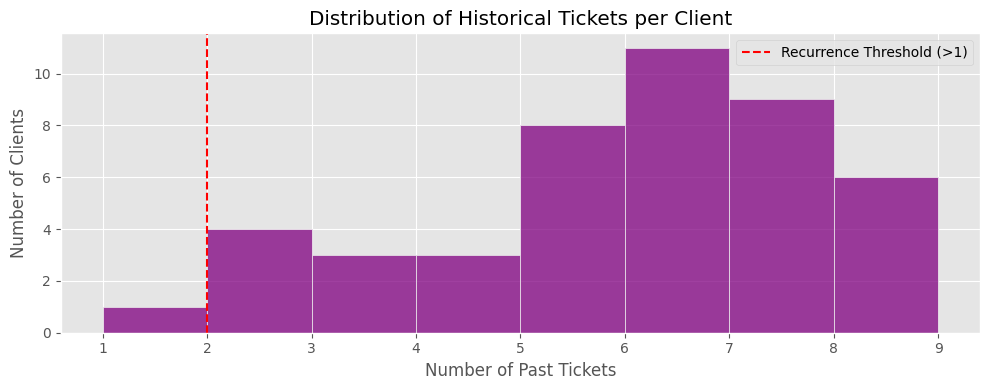

In [13]:
# --- 1. Load & Preprocess ---
history = pd.read_csv('data/ticket_history.csv')
tickets = pd.read_csv('data/tickets.csv') # Needed for overlap check
clients = pd.read_csv('data/clients.csv') # Needed for validity check

# Convert dates
history['created_at'] = pd.to_datetime(history['created_at'])

print(f"Historical Records Loaded: {len(history)}")

# --- PART A: STRUCTURAL INTEGRITY ---
print("\n--- ARCHIVE STRUCTURE AUDIT ---")

# 1. Overlap Check (The "Double Counting" Risk)
# Do any Ticket IDs in History also exist in the Active Tickets table?
common_ids = set(history['ticket_id']).intersection(set(tickets['ticket_id']))
print(f"1. Overlap with Active Tickets: {len(common_ids)}")

# 2. Referential Integrity
# Do historical tickets belong to existing clients?
orphans = history[~history['client_id'].isin(clients['client_id'])]
print(f"2. Orphaned Historical Records (Client not found): {len(orphans)}")

# 3. Completion Check
# Are there unresolved tickets hiding in the history folder?
unresolved_history = history[history['was_resolved'] == False]
print(f"3. Unresolved tickets in History: {len(unresolved_history)}")

# --- PART B: RECURRENCE UTILITY CHECK ---
print("\n--- RECURRENCE VIABILITY ---")

# We need to prove that "Repeat Offenders" actually exist.
# If every client only has 1 historical ticket, the Recurrence Feature is useless.
client_counts = history.groupby('client_id').size().reset_index(name='ticket_count')

repeat_offenders = client_counts[client_counts['ticket_count'] > 1]
high_risk = client_counts[client_counts['ticket_count'] > 3]

print(f"Total Unique Clients in History: {len(client_counts)}")
print(f"Clients with > 1 ticket (Repeaters): {len(repeat_offenders)}")
print(f"Clients with > 3 tickets (Chronic): {len(high_risk)}")

# --- VISUALIZATION: The "Chronic Complainer" Distribution ---
if not client_counts.empty:
    plt.figure(figsize=(10, 4))
    sns.histplot(client_counts['ticket_count'], bins=range(1, 10), kde=False, color='purple')
    plt.title("Distribution of Historical Tickets per Client")
    plt.xlabel("Number of Past Tickets")
    plt.ylabel("Number of Clients")
    plt.xticks(range(1, 10))
    plt.axvline(x=2, color='red', linestyle='--', label='Recurrence Threshold (>1)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Anchor Discovery & Validation

### 1. Why we used Groq (LLM) for Discovery
Instead of guessing what an "Urgent" or "Safe" message looks like (Human Bias), we used an LLM to analyze the raw dataset and extract the **exact semantic signatures** of this specific customer base.

* **Pattern Recognition:** The LLM detected that "Zombie" messages in this dataset are highly repetitive (*"I appreciate your assistance"* appears 26 times), creating a specific "fingerprint" we can target.
* **Anomaly Detection:** A human might miss that a message starting with *"I understand your concern"* is actually an Agent. The LLM flagged this as a "Fake Agent" immediately.
* **Bias Removal:** We use the *customers' actual words*, not our assumptions of them.

In [4]:
import os
import pandas as pd
import json
import re
import random
from dotenv import load_dotenv
from groq import Groq

# 1. Setup Environment
load_dotenv()
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

# --- CONFIGURATION ---
SAMPLES_PER_RUN = 150
MINING_ITERATIONS = 3   # How many times to query the AI for examples
TARGET_BALANCE = 25     # The exact number of examples to keep per class

# --- DATA LOADING ---
print("Loading Data...")
try:
    df = pd.read_csv('data/conversations.csv')
    
    # 1. Extract Customer Text
    customer_df = df[df['sender_type'] == 'customer']
    customer_texts = customer_df['message_text'].dropna().tolist()
    
    # 2. Extract Agent Text
    agent_df = df[df['sender_type'] != 'customer']
    agent_texts = agent_df['message_text'].dropna().tolist()
    
    print(f"Loaded {len(customer_texts)} Customer messages.")
    print(f"Loaded {len(agent_texts)} Agent messages.")
    
except FileNotFoundError:
    print("Error: Data file not found.")
    exit()

def clean_and_split(raw_list):
    """
    Splits text into sentences.
    UPDATED: Lowered min_length to 3 to catch short chasers like "Any updates?"
    """
    units = []
    for text in raw_list:
        splits = re.split(r'[.!?\n]', str(text))
        for s in splits:
            clean_s = s.strip()
            # Keep sentences between 3 and 45 words (Lowered from 5)
            if 3 <= len(clean_s.split()) <= 45:
                units.append(clean_s)
    return list(set(units))

customer_units = clean_and_split(customer_texts)
agent_units = clean_and_split(agent_texts)

# --- HELPER: SANITIZER (CRITICAL UPDATE) ---
def is_truly_polite(text):
    """
    Verifies that a 'Polite' phrase is purely passive.
    Returns FALSE if the user is complaining OR actively checking in.
    """
    text = text.lower()
    
    # 1. Explicit Negativity
    danger_words = [
        "error", "fail", "trouble", "frustrat", "issue", "problem", 
        "bug", "stuck", "cannot", "can't", "doesn't work", "not working",
        "missing", "delay", "silence", "no update", "still", "however", "afraid"
    ]
    
    # 2. "Polite Chasers" (These are RISKS, not passive waiting)
    action_triggers = [
        "check in", "checking in", "follow up", "following up",
        "any update", "any news", "status", "progress", "timeline",
        "eta", "haven't heard", "wondering", "waiting for"
    ]

    if any(w in text for w in danger_words): return False
    if any(w in text for w in action_triggers): return False # <--- Moves "Checking in" to Risk
    
    return True

# --- MINING ACCUMULATOR ---
raw_pools = {
    "URGENT_RISK": [],
    "POLITE_WAITING": [],
    "ZOMBIE_SAFE": [],
    "FAKE_AGENT": []
}

# --- PHASE 1: MINE CUSTOMER SIGNALS ---
print(f"\nMining Customer Signals ({MINING_ITERATIONS} Iterations)...")

for i in range(MINING_ITERATIONS):
    print(f"   Processing iteration {i+1}...")
    sample = random.sample(customer_units, min(SAMPLES_PER_RUN, len(customer_units)))
    
    prompt = f"""
    Analyze these messages and extract sentences into 3 categories.
    
    1. [URGENT_RISK]: 
       - Complaints, frustration, financial issues, bugs.
       - "Polite Chasing" (e.g., "Just checking in", "Any updates?", "Still waiting?").
    
    2. [POLITE_WAITING]: 
       - Purely PASSIVE acknowledgment. 
       - The user is NOT asking a question.
       - Examples: "Understood, thanks", "I will wait for the email", "Thanks for letting me know".
       - DO NOT include "Checking in" messages here.
    
    3. [ZOMBIE_SAFE]: 
       - Closing remarks indicating resolution.
       - Examples: "All good", "Thanks for the help", "It works now".

    SOURCE TEXT:
    {json.dumps(sample)}

    OUTPUT JSON FORMAT: {{ "URGENT_RISK": [], "POLITE_WAITING": [], "ZOMBIE_SAFE": [] }}
    """
    
    try:
        completion = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3,
            response_format={"type": "json_object"}
        )
        data = json.loads(completion.choices[0].message.content)
        for key in ["URGENT_RISK", "POLITE_WAITING", "ZOMBIE_SAFE"]:
            raw_pools[key].extend(data.get(key, []))
    except Exception as e:
        print(f"     Error during mining: {e}")

# --- PHASE 2: MINE AGENT SIGNALS ---
print(f"\nMining Agent Signals ({MINING_ITERATIONS} Iterations)...")

for i in range(MINING_ITERATIONS):
    print(f"   Processing iteration {i+1}...")
    sample = random.sample(agent_units, min(SAMPLES_PER_RUN, len(agent_units)))
    
    prompt = f"""
    Extract standard Support Agent phrases.
    Target Category: [FAKE_AGENT]
    Examples: "I have escalated", "Thank you for your patience", "Our team is working on it".

    SOURCE TEXT:
    {json.dumps(sample)}

    OUTPUT JSON FORMAT: {{ "FAKE_AGENT": [] }}
    """
    
    try:
        completion = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2,
            response_format={"type": "json_object"}
        )
        data = json.loads(completion.choices[0].message.content)
        raw_pools["FAKE_AGENT"].extend(data.get("FAKE_AGENT", []))
    except:
        pass

# --- PHASE 3: PROCESSING & BALANCING ---
print("\nSanitizing and Balancing Data Classes...")

final_anchors = {}

# 1. Deduplicate
for key in raw_pools:
    raw_pools[key] = list(set(raw_pools[key]))

# 2. Sanitize POLITE_WAITING (The Guillotine)
clean_polite = []
rejected_polite = []

for text in raw_pools["POLITE_WAITING"]:
    if is_truly_polite(text):
        clean_polite.append(text)
    else:
        rejected_polite.append(text) # These are "Polite Chasers" -> Move to Risk

raw_pools["POLITE_WAITING"] = clean_polite
raw_pools["URGENT_RISK"].extend(rejected_polite) 
raw_pools["URGENT_RISK"] = list(set(raw_pools["URGENT_RISK"])) 

# 3. Force Balance
for key in raw_pools:
    candidates = raw_pools[key]
    random.shuffle(candidates)
    selected = candidates[:TARGET_BALANCE]
    
    # Fail-safe injection
    if len(selected) < 5:
        print(f"Warning: {key} yielded low results. Adding default phrases.")
        defaults = {
            "FAKE_AGENT": ["Thank you for your patience", "I have escalated this issue", "Our team is working on it"],
            "POLITE_WAITING": ["Thanks for the update", "I will wait for your response", "Understood, thanks"],
            "ZOMBIE_SAFE": ["All good", "Thanks for your help", "The issue is resolved"],
            "URGENT_RISK": ["This is broken", "Any updates?", "Just checking in", "This is frustrating"]
        }
        selected.extend(defaults.get(key, []))
        
    final_anchors[key] = selected
    print(f"   {key}: {len(selected)} items")

# --- SAVE ---
wrapper = {"groups": final_anchors}
with open("anchor_candidates.json", "w") as f:
    json.dump(wrapper, f, indent=2)

print("\n------------------------------------------------")
print("SUCCESS: Balanced Semantic Brain Generated.")
print("------------------------------------------------")

Loading Data...
Loaded 661 Customer messages.
Loaded 483 Agent messages.

Mining Customer Signals (3 Iterations)...
   Processing iteration 1...
   Processing iteration 2...
   Processing iteration 3...

Mining Agent Signals (3 Iterations)...
   Processing iteration 1...
   Processing iteration 2...
   Processing iteration 3...

Sanitizing and Balancing Data Classes...
   URGENT_RISK: 25 items
   POLITE_WAITING: 25 items
   ZOMBIE_SAFE: 25 items
   FAKE_AGENT: 25 items

------------------------------------------------
SUCCESS: Balanced Semantic Brain Generated.
------------------------------------------------


# The Ontop Priority Score

In [1]:
# Libraries
import os
import json
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
from groq import Groq

In [2]:
load_dotenv()

class OntopPriorityEngine:
    def __init__(self, data_dir='data/', anchor_file='anchor_candidates.json'):
        self.anchor_file = anchor_file
        self.data_dir = data_dir
        self.client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        
        # --- LOAD DATA ---
        print("Loading Operational Data...")
        try:
            self.tickets = pd.read_csv(f'{data_dir}tickets.csv')
            self.clients = pd.read_csv(f'{data_dir}clients.csv')
            self.history = pd.read_csv(f'{data_dir}ticket_history.csv')
            self.conversations = pd.read_csv(f'{data_dir}conversations.csv')
            
            self.tickets['created_at'] = pd.to_datetime(self.tickets['created_at'])
            self.conversations['sent_at'] = pd.to_datetime(self.conversations['sent_at'])
        except FileNotFoundError:
            print("Data not found.")
            exit()
        
        # --- LOAD BRAIN ---
        print("Initializing..")
        self.brain = self._load_brain(self.anchor_file)

    def _load_brain(self, filepath):
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
                groups = data['groups'] if 'groups' in data else data
        except FileNotFoundError:
            groups = {}

        # 1. RISK (Urgent)
        risk_text = groups.get('URGENT_RISK', [])
        # 2. POLITE (Passive)
        polite_text = groups.get('POLITE_WAITING', [])
        # 3. IGNORE (Agents/Zombies)
        ignore_text = groups.get('ZOMBIE_SAFE', []) + groups.get('FAKE_AGENT', [])
        
        embeddings = {
            "RISK": [self._get_embedding(t) for t in risk_text if t],
            "POLITE": [self._get_embedding(t) for t in polite_text if t],
            "IGNORE": [self._get_embedding(t) for t in ignore_text if t]
        }
        return embeddings

    def _get_embedding(self, text):
        if not text: return np.zeros(1536)
        # Using text-embedding-3-small
        return self.client.embeddings.create(input=[text.replace("\n", " ")], model="text-embedding-3-small").data[0].embedding

    def _check_safety_net(self, text):
        """
        GUARD DOG: Checks for explicit triggers.
        UPDATED: Now ignores Agents using "Empathy Scripts".
        """
        text_lower = text.lower()
        
        # --- THE MUZZLE (Agent filters) ---
        # If it sounds like an Agent, ignore the safety net triggers.
        # Agents often say "frustrating" when empathizing.
        agent_indicators = [
            "thank you for your patience", 
            "i understand how frustrating", 
            "i understand your frustration",
            "apologize for the delay",
            "let me provide you",
            "happy to help"
        ]
        
        if any(phrase in text_lower for phrase in agent_indicators):
            return False  # Abort! Do not trigger Safety Net.

        # --- THE TEETH (Triggers) ---
        # 1. PANIC TRIGGERS (Angry/Broken)
        panic_triggers = [
            "frustrat", "unacceptable", "disappoint", "ridiculous", 
            "waste of time", "waiting for days", "still waiting",
            "immediate", "urgent", "asap", "emergency", "fail",
            "not working", "error", "unable to", "hello?", "???", "!!!"
        ]
        
        # 2. POLITE URGENCY (The "Nice but Needs Help" Patch)
        polite_urgency = [
            "resolve this", "fix this", "update on", "status of",
            "next steps", "timeline", "eager to", "look into"
        ]
        
        # 3. The "But..." Trap
        if "but" in text_lower or "however" in text_lower:
            negatives = ["still", "issue", "haven't", "hasn't"]
            if any(n in text_lower for n in negatives):
                return True

        if any(t in text_lower for t in panic_triggers): return True
        if any(t in text_lower for t in polite_urgency): return True
            
        return False

    def _calculate_semantic_urgency(self, target_text):
        if not target_text: return 0
        
        # --- LAYER 1: THE SAFETY NET (Keyword Override) ---
        # If the user is explicitly angry, do not trust the vectors.
        if self._check_safety_net(target_text):
            return 85.0 # High base score for explicit risk
            
        # --- LAYER 2: VECTOR BRAIN ---
        msg_vector = np.array([self._get_embedding(target_text)])
        
        risk_sim = np.max(cosine_similarity(msg_vector, np.array(self.brain['RISK']))[0]) if self.brain['RISK'] else 0
        ignore_sim = np.max(cosine_similarity(msg_vector, np.array(self.brain['IGNORE']))[0]) if self.brain['IGNORE'] else 0
        polite_sim = np.max(cosine_similarity(msg_vector, np.array(self.brain['POLITE']))[0]) if self.brain['POLITE'] else 0
        
        # 1. Strong Vector Match Override
        if risk_sim > 0.60:
            return 50 + ((risk_sim - 0.60) * 100)

        # 2. Safe Filter (Agent/Zombie)
        if ignore_sim > risk_sim:
            return 0
            
        # 3. Polite Filter (The dangerous one)
        # Only filter if Polite is CLEARLY dominant
        if polite_sim > (risk_sim * 1.1):
            return 0
        
        # 4. Weak Match Floor
        if risk_sim < 0.42:
            return 0
            
        return 50 + ((risk_sim - 0.42) * 100)

    def process_queue(self):
        print("Processing Ticket Queue...")
        open_tickets = self.tickets[self.tickets['status'].isin(['open', 'pending'])].copy()
        results = []
        
        for _, ticket in open_tickets.iterrows():
            t_id = ticket['ticket_id']
            msgs = self.conversations[self.conversations['ticket_id'] == t_id].sort_values('sent_at')
            
            if not msgs.empty:
                last_msg_row = msgs.iloc[-1]
                target_text = str(last_msg_row['message_text'])
                
                # VETO 1: Sender is Agent (Trust DB)
                if last_msg_row['sender_type'] != 'customer':
                    results.append({'ticket_id': t_id, 'final_score': 0, 'last_message_full': target_text})
                    continue
            else:
                target_text = ""

            # --- CALCULATE SCORES ---
            # Financial (MRR)
            client_row = self.clients[self.clients['client_id'] == ticket['client_id']]
            if not client_row.empty:
                mrr = client_row.iloc[0]['mrr']
                tier_mult = 1.5 if client_row.iloc[0]['account_tier'] == 'enterprise' else 1.0
                fin_score = min(np.log10(mrr + 1) * 5 * tier_mult, 30)
            else:
                fin_score = 0
            
            # Recency
            hist_count = len(self.history[self.history['client_id'] == ticket['client_id']])
            rec_score = 15 if hist_count > 5 else 0
            time_score = min((pd.Timestamp.now() - ticket['created_at']).days, 20)
            
            # AI Score (Hybrid: Vectors + Safety Net)
            ai_score = self._calculate_semantic_urgency(target_text)
            
            # Total
            total_score = (fin_score + rec_score + time_score + ai_score) if ai_score > 0 else 0
            
            results.append({
                'ticket_id': t_id,
                'final_score': round(total_score, 1),
                'last_message_full': target_text
            })
            
        return pd.DataFrame(results).sort_values('final_score', ascending=False)

if __name__ == "__main__":
    if os.path.exists('priority_output.csv'):
        os.remove('priority_output.csv')

    engine = OntopPriorityEngine()
    df = engine.process_queue()
    df.to_csv('priority_output.csv', index=False)
    
    print(f"\nDone. Processed {len(df)} tickets.")
    print(f"Urgent Tickets (Score > 0): {len(df[df['final_score'] > 0])}")
    print(f"Ignored Tickets (Score 0): {len(df[df['final_score'] == 0])}")

Loading Operational Data...
Initializing..
Processing Ticket Queue...

Done. Processed 111 tickets.
Urgent Tickets (Score > 0): 70
Ignored Tickets (Score 0): 41


# Validation

In [3]:
import json
from groq import Groq
import pandas as pd

# Initialize Groq
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

def calculate_precision_at_k(df, k=30):
    """
    Selects the Top K tickets and asks Llama-3 to audit them.
    Calculates accuracy using Python to ensure 100% math precision.
    """
    # 1. Select Candidates
    candidates = df.head(k)[['ticket_id', 'last_message_full', 'final_score']].to_dict(orient='records')
    
    print(f"Auditing Top {len(candidates)} tickets with AI Judge...")

    # 2. The Judge's Prompt (Simplified)
    prompt = f"""
    You are a Quality Assurance Auditor. Review these Support Tickets.
    
    CRITERIA FOR 'CORRECT' (True Positive):
    - Customer is waiting, frustrated, asking for help, or reporting a bug.
    
    CRITERIA FOR 'WRONG' (False Positive):
    - Text is from a Support Agent (e.g. "I have checked", "Thank you for patience").
    - Text is a polite closing (e.g. "Thank you", "All good") with no active issue.
    
    TICKETS:
    {json.dumps(candidates)}
    
    OUTPUT JSON ONLY:
    {{
        "results": [
            {{ "ticket_id": "...", "verdict": "CORRECT" or "WRONG", "reason": "short explanation" }}
        ]
    }}
    """
    
    # 3. AI Execution
    completion = client.chat.completions.create(
        model="llama-3.3-70b-versatile",
        messages=[{"role": "system", "content": "Output JSON only."}, {"role": "user", "content": prompt}],
        temperature=0,
        response_format={"type": "json_object"}
    )
    
    # 4. Reliable Calculation (Python Math)
    try:
        data = json.loads(completion.choices[0].message.content)
        audit_log = data['results']
        
        # Count strictly using Python
        correct_count = sum(1 for item in audit_log if item['verdict'] == 'CORRECT')
        total_count = len(audit_log)
        
        if total_count == 0:
            return 0, []
            
        real_accuracy = (correct_count / total_count) * 100
        
        return real_accuracy, audit_log
        
    except Exception as e:
        print(f"Error parsing AI response: {e}")
        return 0, []

# --- RUN THE AUDIT ---
# Load your finalized CSV
final_df = pd.read_csv('priority_output.csv')

# Run
accuracy_score, audit_log = calculate_precision_at_k(final_df, k=30)

print(f"\nSYSTEM CONFIDENCE (Precision@{len(audit_log)}): {accuracy_score:.2f}%")
print("\n--- Detailed Audit ---")
for entry in audit_log:
    is_correct = "TRUE" if entry['verdict'] == "CORRECT" else "FALSE"
    print(f"{is_correct} {entry['ticket_id']}: {entry['reason']}")

Auditing Top 30 tickets with AI Judge...

SYSTEM CONFIDENCE (Precision@30): 96.67%

--- Detailed Audit ---
TRUE 64d24278: Customer is frustrated and waiting for an update on their payment
TRUE 37bfeff0: Customer is following up on their payment status and eager for an update
TRUE 5b995d3b: Customer is waiting for an update on a pending transaction
TRUE 23189e16: Customer is checking in on the status of documentation for employee training records
TRUE cfa9e0ea: Customer is checking in on the status of their payout
TRUE c74be23e: Customer is seeking further assistance with a payment issue
TRUE a77a3f99: Customer is following up on an error message and seeking assistance
TRUE a578fc66: Customer is seeking additional steps to resolve an issue
TRUE f0c4cdb3: Customer is frustrated and seeking a timeline for a resolution
TRUE 1a23a167: Customer is seeking advice on the next steps to resolve an issue
TRUE aa5d73ff: Customer is checking in on the status of their onboarding process
TRUE 784d348

In [4]:
import pandas as pd
from IPython.display import display, HTML

# 1. Define the "Hellfire" Dataset (Synthetic Data)
# These are designed to trick the AI (Slang, Politeness, Agent Mimicry)
synthetic_data = [ 
    # TYPE 1: Slang & Casual (Tests Generalization)
    {"id": "syn_4", "truth": "URGENT", "text": "bruh the app is totally bricked rn, cant login at all."},
    {"id": "syn_5", "truth": "URGENT", "text": "yo is the server down? getting 500 errors everywhere."},
    {"id": "syn_6", "truth": "URGENT", "text": "this update is trash, it broke my entire workflow."},
    
    # TYPE 2: The "Tricky Safe" (Tests Safety Net Over-Aggression)
    {"id": "syn_8", "truth": "SAFE", "text": "No urgent issues here, just wanted to say the new feature is great."},
    {"id": "syn_9", "truth": "SAFE", "text": "I will wait for the update next week, no rush."},
    
    # TYPE 3: Agent Mimicry (Tests Muzzle)
    {"id": "syn_10", "truth": "SAFE", "text": "Thank you for your patience while we investigated the logs."},
    {"id": "syn_11", "truth": "SAFE", "text": "I understand how frustrating this is, let me escalate this for you."},
    {"id": "syn_12", "truth": "SAFE", "text": "Please feel free to reach out if the issue persists."},
    
    # TYPE 4: The "Polite Chaser" (Tests Recent Logic Fixes)
    {"id": "syn_13", "truth": "URGENT", "text": "Just checking in on this?"},
    {"id": "syn_14", "truth": "URGENT", "text": "Any updates on the ticket I submitted Monday?"},
    {"id": "syn_15", "truth": "URGENT", "text": "I don't mean to be a bother, but has there been any progress?"},
    
    # TYPE 5: Contextual Failures (Tests Keywords in Context)
    {"id": "syn_16", "truth": "URGENT", "text": "The export button does nothing when I click it."},
    {"id": "syn_17", "truth": "URGENT", "text": "Still seeing the same error code 404."},
    {"id": "syn_18", "truth": "URGENT", "text": "It works on mobile but crashes on desktop."},
    
    # TYPE 6: Mixed Signals (Hardest Category)
    {"id": "syn_20", "truth": "SAFE", "text": "I thought it was broken, but actually I just forgot to save. My bad!"},
    {"id": "syn_21", "truth": "URGENT", "text": "Love the app usually, but this bug is killing me."},

    # TYPE 7: The "Short & Angry"
    {"id": "syn_22", "truth": "URGENT", "text": "Unacceptable."},
    {"id": "syn_23", "truth": "URGENT", "text": "Fix this now."},
    {"id": "syn_24", "truth": "URGENT", "text": "Hello???"},

    # TYPE 8: The "Corporate Professional" (Formal Risk)
    {"id": "syn_25", "truth": "URGENT", "text": "Please be advised that we are considering churning if this persists."},
    {"id": "syn_26", "truth": "URGENT", "text": "This downtime is violating our SLA."},

    # TYPE 9: Pure Gratitude (Baseline Safe)
    {"id": "syn_27", "truth": "SAFE", "text": "You guys are the best, thanks!"},
    {"id": "syn_28", "truth": "SAFE", "text": "Ticket closed, thank you."},
    {"id": "syn_29", "truth": "SAFE", "text": "All good now."},
    {"id": "syn_30", "truth": "SAFE", "text": "Perfect, that worked."}
]

# 2. Run the Stress Test
print(f"Running Stress Test on {len(synthetic_data)} items...")

# Assuming 'engine' is already instantiated in your notebook. 
# If not, uncomment the next line:
# engine = OntopPriorityEngine()

results = []

for item in synthetic_data:
    # DIRECT ACCESS: We call the brain function directly.
    # We don't need real IDs because we aren't looking up Client History or MRR.
    # We are only testing if the AI understands the TEXT.
    score = engine._calculate_semantic_urgency(item['text'])
    
    # Verdict: If score > 0, the system marked it as Urgent/High Priority
    system_verdict = "URGENT" if score > 0 else "SAFE"
    is_match = item['truth'] == system_verdict
    
    results.append({
        "Text": item['text'],
        "Truth": item['truth'],
        "System Verdict": system_verdict,
        "Score": round(score, 1),
        "Pass": "TRUE" if is_match else "FALSE"
    })

# 3. Display Results
results_df = pd.DataFrame(results)

# Calculate Accuracy
accuracy = (results_df['Pass'] == "TRUE").mean() * 100

print(f"GENERALIZATION ACCURACY: {accuracy:.1f}%")
print("-" * 60)

# Show Failures First (If any)
failures = results_df[results_df['Pass'] == "FALSE"]
if not failures.empty:
    print("\nFAILED CASES (Model Confusion):")
    display(failures)

# Show Successes (Verification)
print("\nFULL RESULTS:")
display(results_df)

Running Stress Test on 25 items...
GENERALIZATION ACCURACY: 88.0%
------------------------------------------------------------

FAILED CASES (Model Confusion):


,Text,Truth,System Verdict,Score,Pass
3,"No urgent issues here, just wanted to say the ...",SAFE,URGENT,85.0,FALSE
8,Just checking in on this?,URGENT,SAFE,0.0,FALSE
11,The export button does nothing when I click it.,URGENT,SAFE,0.0,FALSE



FULL RESULTS:


,Text,Truth,System Verdict,Score,Pass
0,"bruh the app is totally bricked rn, cant login...",URGENT,URGENT,55.8,TRUE
1,yo is the server down? getting 500 errors ever...,URGENT,URGENT,85.0,TRUE
2,"this update is trash, it broke my entire workf...",URGENT,URGENT,58.6,TRUE
3,"No urgent issues here, just wanted to say the ...",SAFE,URGENT,85.0,FALSE
4,"I will wait for the update next week, no rush.",SAFE,SAFE,0.0,TRUE
5,Thank you for your patience while we investiga...,SAFE,SAFE,0.0,TRUE
6,"I understand how frustrating this is, let me e...",SAFE,SAFE,0.0,TRUE
7,Please feel free to reach out if the issue per...,SAFE,SAFE,0.0,TRUE
8,Just checking in on this?,URGENT,SAFE,0.0,FALSE
9,Any updates on the ticket I submitted Monday?,URGENT,URGENT,54.4,TRUE
